In [66]:
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

In [67]:
config = {
    "train_batchsz" : 64,
    "epoch" : 120,
    "lr" : 1.0e-3,
    "betas" : (0., 0.999),
    "mnistm_path" : "/data/dlcv/hw2/hw2_data/digits/mnistm/",
    "usps_path" : "/data/dlcv/hw2/hw2_data/digits/usps/",
    "device" :  "cuda" if torch.cuda.is_available() else "cpu",
    "numofclass" : 10,
    "lamb" : 0.2,
}
source_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
])
if config["device"] == "cuda":
    torch.cuda.set_device(2)
print('Device used :', config["device"])

Device used : cuda


In [68]:
class USPS_FeatureExtractor(nn.Module):
    def __init__(self, channel=1):
        super(USPS_FeatureExtractor, self).__init__()
        self.conv1 = self.block(dim_in=channel, dim_out=64) #(bsz, 64, 14, 14)
        self.conv2 = self.block(dim_in=64, dim_out=128) #(bsz, 128, 7, 7)
        self.conv3 = self.block(dim_in=128, dim_out=256, pad=0, maxpool=False) #(bsz, 256, 5, 5)
        self.conv4 = self.block(dim_in=256, dim_out=256, pad=0, maxpool=False) #(bsz, 256, 3, 3)
        self.conv5 = self.block(dim_in=256, dim_out=512, pad=0, maxpool=False) #(bsz, 512, 1, 1)
    def block(self, dim_in, dim_out, ksz=3, stride_=1, pad=1, maxpool=True):
        if maxpool:
            return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=pad),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(True),
                nn.MaxPool2d(2)
            )
        return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=pad),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(True)
            )    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        return x5.flatten(1)

In [69]:
class USPS_LabelPredictor(nn.Module):
    def __init__(self):
        super(USPS_LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, config["numofclass"])
        )
    def forward(self, h):
        c = self.layer(h)
        return c

In [70]:
class USPS_DomainClassifier(nn.Module):
    def __init__(self):
        super(USPS_DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1),
        )
    def forward(self, h):
        y = self.layer(h)
        return y

In [71]:
class DigitDataset(Dataset):
    def __init__(self, datapath, csvpath=None, transform=None) -> None:
        self.data = []
        if os.path.exists(datapath):
            if csvpath is None:
                filenames = glob.glob(os.path.join(datapath, "*.png"))
                for filename in filenames:
                    self.data.append((filename, ))
            elif os.path.exists(csvpath):
                df = pd.read_csv(csvpath)
                self.data = [(os.path.join(datapath, name), label) for name, label in zip(df["image_name"], df["label"])]
            else:
                print("Can't find {}".format(csvpath))
                exit(-1)
        else:
            print("Can't find {}".format(datapath))
            exit(-1)
        self.len = len(self.data)
        self.transform = transform

    def __getitem__(self, index):
        img_fn, label = self.data[index]
        img = Image.open(img_fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return self.len

In [72]:
def imshow(img):
    # img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to {}'.format(checkpoint_path))
def load_checkpoint(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    return checkpoint["model_state_dict"], checkpoint["optimizer_state_dict"]

In [73]:
class DANN_USPS():
    def __init__(self) -> None:
        self.F = USPS_FeatureExtractor().to(config["device"])
        self.C = USPS_LabelPredictor().to(config["device"])
        self.D = USPS_DomainClassifier().to(config["device"])

        self.class_criterion = nn.CrossEntropyLoss()
        self.domain_criterion = nn.BCEWithLogitsLoss()

        self.optimizer_F = optim.Adam(self.F.parameters())
        self.optimizer_C = optim.Adam(self.C.parameters())
        self.optimizer_D = optim.Adam(self.D.parameters())

    def CreateLoader(self):
        self.mnistm_train_loader = DataLoader(DigitDataset(datapath=os.path.join(config["mnistm_path"], "data"), csvpath=os.path.join(config["mnistm_path"], "train.csv"), transform=source_transform), 
                                            batch_size=config["train_batchsz"], shuffle=True)
        self.mnistm_val_loader = DataLoader(DigitDataset(datapath=os.path.join(config["mnistm_path"], "data"), csvpath=os.path.join(config["mnistm_path"], "val.csv"), transform=val_transform),
                                            batch_size=config["train_batchsz"], shuffle=False)
        self.usps_train_loader = DataLoader(DigitDataset(datapath=os.path.join(config["usps_path"], "data"), csvpath=os.path.join(config["usps_path"], "train.csv"), transform=target_transform), 
                                            batch_size=config["train_batchsz"], shuffle=True)
        self.usps_val_loader = DataLoader(DigitDataset(datapath=os.path.join(config["usps_path"], "data"), csvpath=os.path.join(config["usps_path"], "val.csv"), transform=val_transform),
                                            batch_size=config["train_batchsz"], shuffle=False)
        # imshow(torchvision.utils.make_grid(next(iter(self.mnistm_train_loader))[0], padding=0))
        # imshow(torchvision.utils.make_grid(next(iter(self.usps_train_loader))[0], padding=0))
        print(len(self.mnistm_train_loader.dataset), len(self.mnistm_val_loader.dataset), len(self.usps_train_loader.dataset), len(self.usps_val_loader.dataset))
    
    def train(self):
        self.CreateLoader()
        lamb = config["lamb"]
        best_acc = 0.
        for ep in range(config["epoch"]):
            self.F.train()
            self.C.train()
            self.D.train()
            F_loss, C_loss, D_loss = 0., 0., 0.
            mnistm_acc, usps_acc = 0, 0
            for idx, ((mnistm_img, mnistm_label), (usps_img, usps_label)) in enumerate(zip(self.mnistm_train_loader, self.usps_train_loader)):
                mnistm_img, usps_img = mnistm_img.to(config["device"]), usps_img.to(config["device"])
                #train domain classifier
                mixed_data = torch.cat([mnistm_img, usps_img], dim=0)
                domain_label = torch.zeros((mnistm_img.shape[0] + usps_img.shape[0], 1), device=config["device"])
                domain_label[:mnistm_img.shape[0]] = 1
                feature = self.F(mixed_data)
                domain_logits = self.D(feature.detach())
                loss = self.domain_criterion(domain_logits, domain_label)
                D_loss += loss.item()
                self.D.zero_grad()
                loss.backward()
                self.optimizer_D.step()
                #train feature extrator & label predictor
                class_logit = self.C(feature[:mnistm_img.shape[0]]).cpu()
                mnistm_acc += (class_logit.argmax(1) == mnistm_label).sum().item()
                domain_logits = self.D(feature)
                loss = self.class_criterion(class_logit, mnistm_label) - lamb * self.domain_criterion(domain_logits, domain_label)
                F_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (usps_img, usps_label) in enumerate(self.usps_val_loader):
                    feature = self.F(usps_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    usps_acc += (y.argmax(1) == usps_label).sum().item()
            if usps_acc > best_acc :
                save_checkpoint("/data/allen/hw2model/mnistm_usps_F.pth", self.F, self.optimizer_F)
                save_checkpoint("/data/allen/hw2model/mnistm_usps_C.pth", self.C, self.optimizer_C)
                save_checkpoint("/data/allen/hw2model/mnistm_usps_D.pth", self.D, self.optimizer_D)
                best_acc = usps_acc
            print("Epoch[{}/{}] D_loss : {:.6f} F_loss : {:.6f} mnistm_acc : {:.2%} usps_acc : {:.2%}".format(ep + 1, config["epoch"], D_loss / idx, F_loss / idx, 
                            mnistm_acc / min(len(self.mnistm_train_loader.dataset), len(self.usps_train_loader.dataset)), usps_acc / len(self.usps_val_loader.dataset)))
    
    def lower_bound(self):
        self.CreateLoader()
        epochs = 35
        for ep in range(epochs):
            self.F.train()
            self.C.train()
            F_loss, C_loss = 0., 0.
            mnistm_acc, usps_acc = 0, 0
            for idx, (mnistm_img, mnistm_label) in enumerate(self.mnistm_train_loader):
                mnistm_img = mnistm_img.to(config["device"])
                #train feature extrator & label predictor
                feature = self.F(mnistm_img)
                class_logit = self.C(feature).cpu()
                mnistm_acc += (class_logit.argmax(1) == mnistm_label).sum().item()
                loss = self.class_criterion(class_logit, mnistm_label)
                F_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (usps_img, usps_label) in enumerate(self.usps_val_loader):
                    feature = self.F(usps_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    usps_acc += (y.argmax(1) == usps_label).sum().item()
            print("Epoch[{}/{}] F_loss : {:.6f} mnistm_acc : {:.2%} usps_acc : {:.2%}".format(ep + 1, epochs, F_loss / idx, 
                    mnistm_acc / len(self.mnistm_train_loader.dataset), usps_acc / len(self.usps_val_loader.dataset)))
    
    def upper_bound(self):
        self.CreateLoader()
        epochs = 35
        for ep in range(epochs):
            self.F.train()
            self.C.train()
            train_loss, val_loss = 0., 0.
            train_usps_acc, val_usps_acc = 0, 0
            for idx, (usps_img, usps_label) in enumerate(self.usps_train_loader):
                usps_img = usps_img.to(config["device"])
                #train feature extrator & label predictor
                feature = self.F(usps_img)
                class_logit = self.C(feature).cpu()
                train_usps_acc += (class_logit.argmax(1) == usps_label).sum().item()
                loss = self.class_criterion(class_logit, usps_label)
                train_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (usps_img, usps_label) in enumerate(self.usps_val_loader):
                    feature = self.F(usps_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    val_loss += self.class_criterion(y, usps_label)
                    val_usps_acc += (y.argmax(1) == usps_label).sum().item()
            print("Epoch[{}/{}] train_loss : {:.6f} train_usps_acc : {:.2%} val_loss : {:.6f} val_usps_acc : {:.2%}".format(ep + 1, epochs, train_loss / idx, 
                    train_usps_acc / len(self.usps_train_loader.dataset), val_loss / idx, val_usps_acc / len(self.usps_val_loader.dataset)))
    def tsne(self):
        self.CreateLoader()
        F_model_checkpoint, __ = load_checkpoint("/data/allen/hw2model/hw2_3_mnistm_usps_F.pth", device=config["device"])
        F = USPS_FeatureExtractor().to(config["device"])
        F.load_state_dict(F_model_checkpoint)
        F.eval()
        colors = np.random.random((config["numofclass"], 3))
        tsne = TSNE(n_components=2, learning_rate='auto', init='random') 
        with torch.no_grad():
            F_outputs, labels, domains = [], [], []
            for (mnistm_img, mnistm_label) in self.mnistm_val_loader:
                mnistm_img = transforms.Grayscale()(mnistm_img).to(config["device"])
                feature = F(mnistm_img)
                F_outputs.append(feature.cpu().numpy())
                labels.append(mnistm_label)
                domains.append(np.ones(mnistm_img.shape[0], dtype=np.int8))
            for (usps_img, usps_label) in self.usps_val_loader:
                usps_img = usps_img.to(config["device"])
                feature = F(usps_img)
                F_outputs.append(feature.cpu().numpy())
                labels.append(usps_label)
                domains.append(np.zeros(usps_img.shape[0], dtype=np.int8))
            F_outputs, labels, domains = np.concatenate(F_outputs, axis=0), np.concatenate(labels, axis=0), np.concatenate(domains, axis=0)
            F_tsne = tsne.fit_transform(F_outputs)
            fig1, fig2 = plt.figure(1), plt.figure(2)
            ax1, ax2 = fig1.add_subplot(111), fig2.add_subplot(111)
            ax1.set_title('By class'), ax2.set_title('By domain')
            ax1.scatter(F_tsne[:,0], F_tsne[:,1], s=2, color=[tuple(colors[i]) for i in labels], alpha=0.4)
            ax2.scatter(F_tsne[:,0], F_tsne[:,1], s=2, color=['r' if i == 1 else 'b' for i in domains], alpha=0.4)
            plt.show()

## Train

In [9]:
model = DANN_USPS()
model.train()

44800 11200 5950 1488
model saved to /data/allen/hw2model/mnistm_usps_F.pth
model saved to /data/allen/hw2model/mnistm_usps_C.pth
model saved to /data/allen/hw2model/mnistm_usps_D.pth
Epoch[1/120] D_loss : 3.143613 F_loss : 5.091910 mnistm_acc : 51.50% usps_acc : 59.95%
model saved to /data/allen/hw2model/mnistm_usps_F.pth
model saved to /data/allen/hw2model/mnistm_usps_C.pth
model saved to /data/allen/hw2model/mnistm_usps_D.pth
Epoch[2/120] D_loss : 2.484025 F_loss : 2.398091 mnistm_acc : 76.87% usps_acc : 61.56%
model saved to /data/allen/hw2model/mnistm_usps_F.pth
model saved to /data/allen/hw2model/mnistm_usps_C.pth
model saved to /data/allen/hw2model/mnistm_usps_D.pth
Epoch[3/120] D_loss : 2.317143 F_loss : 1.955196 mnistm_acc : 80.82% usps_acc : 73.86%
Epoch[4/120] D_loss : 2.325134 F_loss : 1.802636 mnistm_acc : 82.24% usps_acc : 71.30%
model saved to /data/allen/hw2model/mnistm_usps_F.pth
model saved to /data/allen/hw2model/mnistm_usps_C.pth
model saved to /data/allen/hw2model/

## Lower bound

In [10]:
model = DANN_USPS()
model.lower_bound()

44800 11200 5950 1488
Epoch[1/35] F_loss : 19.399553 mnistm_acc : 78.92% usps_acc : 71.30%
Epoch[2/35] F_loss : 12.405144 mnistm_acc : 86.73% usps_acc : 74.40%
Epoch[3/35] F_loss : 10.232253 mnistm_acc : 88.95% usps_acc : 69.96%
Epoch[4/35] F_loss : 8.850791 mnistm_acc : 90.54% usps_acc : 67.81%
Epoch[5/35] F_loss : 7.782923 mnistm_acc : 91.48% usps_acc : 69.76%
Epoch[6/35] F_loss : 7.187615 mnistm_acc : 92.23% usps_acc : 68.08%
Epoch[7/35] F_loss : 6.416230 mnistm_acc : 93.00% usps_acc : 72.11%
Epoch[8/35] F_loss : 5.898388 mnistm_acc : 93.60% usps_acc : 65.52%
Epoch[9/35] F_loss : 5.399160 mnistm_acc : 94.09% usps_acc : 64.18%
Epoch[10/35] F_loss : 4.961407 mnistm_acc : 94.59% usps_acc : 63.78%
Epoch[11/35] F_loss : 4.514418 mnistm_acc : 95.09% usps_acc : 63.84%
Epoch[12/35] F_loss : 4.167796 mnistm_acc : 95.34% usps_acc : 64.78%
Epoch[13/35] F_loss : 3.884575 mnistm_acc : 95.67% usps_acc : 64.99%
Epoch[14/35] F_loss : 3.654395 mnistm_acc : 95.85% usps_acc : 63.04%
Epoch[15/35] F_los

## Upper bound

In [11]:
model = DANN_USPS()
model.upper_bound()

44800 11200 5950 1488
Epoch[1/35] train_loss : 1.508313 train_usps_acc : 88.76% val_loss : 0.211337 val_usps_acc : 94.15%
Epoch[2/35] train_loss : 0.487576 train_usps_acc : 96.55% val_loss : 0.100912 val_usps_acc : 97.78%
Epoch[3/35] train_loss : 0.366035 train_usps_acc : 97.61% val_loss : 0.115983 val_usps_acc : 97.04%
Epoch[4/35] train_loss : 0.243728 train_usps_acc : 98.22% val_loss : 0.107386 val_usps_acc : 97.72%
Epoch[5/35] train_loss : 0.250246 train_usps_acc : 98.27% val_loss : 0.147984 val_usps_acc : 96.57%
Epoch[6/35] train_loss : 0.244858 train_usps_acc : 98.37% val_loss : 0.103786 val_usps_acc : 97.78%
Epoch[7/35] train_loss : 0.237911 train_usps_acc : 98.42% val_loss : 0.066858 val_usps_acc : 98.59%
Epoch[8/35] train_loss : 0.247323 train_usps_acc : 98.24% val_loss : 0.059665 val_usps_acc : 98.72%
Epoch[9/35] train_loss : 0.177646 train_usps_acc : 98.79% val_loss : 0.057940 val_usps_acc : 98.66%
Epoch[10/35] train_loss : 0.222499 train_usps_acc : 98.49% val_loss : 0.066155

## t-sne

44800 11200 5950 1488


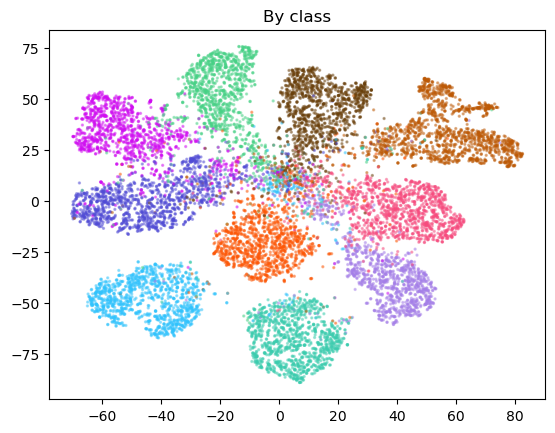

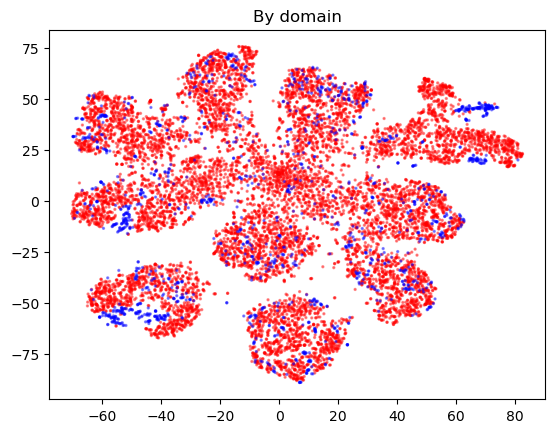

In [74]:
model = DANN_USPS()
model.tsne()